In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import norm

from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_predict, KFold, StratifiedKFold, cross_val_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, silhouette_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

### TASK 1

In [49]:
# loading the dataset


# Load the dataset with proper delimiter and encoding
file_path = 'earnings.csv'
df = pd.read_csv(file_path, delimiter=';', encoding='utf-8')

# Display the first few rows of the dataframe
print("First 5 rows of the dataset:")
print(df.head())

First 5 rows of the dataset:
       id      base   bonus  overtime_pay    other  sector  section_07  sex  \
0  192064  26651.53     0.0          0.00     0.00       1           3    2   
1   25495  40168.50  1500.0          0.00  3414.32       1           2    1   
2  142164  20134.80     0.0          0.00  1700.41       1           2    2   
3  198034  16475.00     0.0          0.00  1305.00       1           2    2   
4  144990  34797.60     0.0       1893.35  3118.73       1           2    2   

   education  contract  age  duration_total  duration_entity  \
0          4         1   49           33.03             7.06   
1          1         1   36           10.07             6.01   
2          4         1   52           28.08            19.05   
3          5         1   55           35.07            11.01   
4          2         1   50           27.00            19.01   

   duration_nominal  duration_overtime  
0           1524.15                0.0  
1           1562.40          

In [50]:

# Generate descriptive statistics for quantitative variables
quantitative_cols = ['base', 'bonus', 'overtime_pay', 'other', 'age', 'duration_total', 'duration_entity', 'duration_nominal', 'duration_overtime']
print("Descriptive statistics for quantitative variables:")
print(df[quantitative_cols].describe())

# Generate frequency tables for qualitative variables
qualitative_cols = ['sector', 'section_07', 'sex', 'education', 'contract']
for col in qualitative_cols:
    print(f"\nFrequency table for {col}:")
    print(df[col].value_counts())


Descriptive statistics for quantitative variables:
                base          bonus   overtime_pay         other  \
count   11000.000000   11000.000000   11000.000000  11000.000000   
mean    33376.738065    2128.486176    1679.273923   2477.625815   
std     19276.551638    4966.444726    5407.964344   3715.419120   
min        10.000000       0.000000       0.000000      0.000000   
25%     20995.115000       0.000000       0.000000      0.000000   
50%     31341.245000     620.000000       0.000000   2141.820000   
75%     41348.290000    2940.717500    1139.330000   3497.430000   
max    241624.390000  258061.000000  228110.340000  88555.760000   

                age  duration_total  duration_entity  duration_nominal  \
count  11000.000000     11000.00000     11000.000000      11000.000000   
mean      42.470182        18.56708        11.401382       1301.307435   
std       10.012140        10.99695         9.322181        540.189234   
min       19.000000         0.01000     

In [55]:
# Check for missing data
print("\nMissing data check:")
print(df.isnull().sum())

# Display data types
print("\nData types:")
print(df.dtypes)

# Display number of unique values for each column
print("\nUnique values per column:")
print(df.nunique())


Missing data check:
id                   0
base                 0
bonus                0
overtime_pay         0
other                0
sector               0
section_07           0
sex                  0
education            0
contract             0
age                  0
duration_total       0
duration_entity      0
duration_nominal     0
duration_overtime    0
dtype: int64

Data types:
id                     int64
base                 float64
bonus                float64
overtime_pay         float64
other                float64
sector                 int64
section_07             int64
sex                    int64
education              int64
contract               int64
age                    int64
duration_total       float64
duration_entity      float64
duration_nominal     float64
duration_overtime    float64
dtype: object

Unique values per column:
id                   11000
base                 10677
bonus                 3833
overtime_pay          3629
other                 80

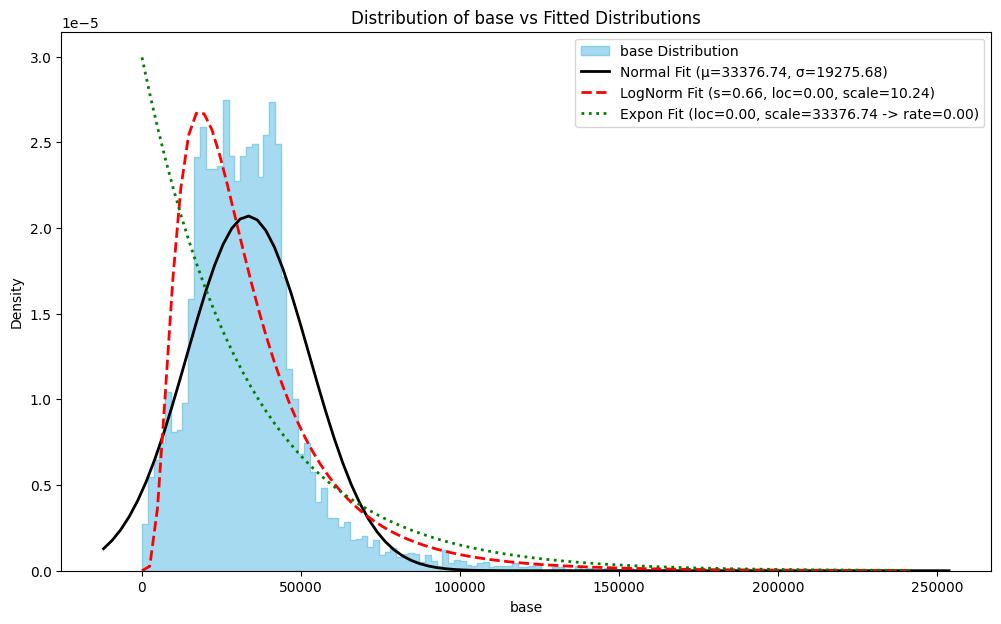

Discussion for base:
  Data Mean: 33376.74, Data Std Dev: 19276.55
  Skewness: 2.12, Kurtosis: 9.97
  Normal Fit: Mean (μ)=33376.74, Std Dev (σ)=19275.68
  LogNormal Fit: Shape (s)=0.66, Loc=0.00, Scale (exp(mu))=28073.07 (mu_log=10.24, sigma_log=0.66)
  Exponential Fit: Loc=0.00, Scale (1/λ)=33376.74 (Rate (λ)=0.00)
  Observations: Compare the histogram to Normal, Log-Normal, and Exponential distributions. Note skewness, presence of zeros/negatives, and how well each curve fits.
----------------------------------------------------------------------


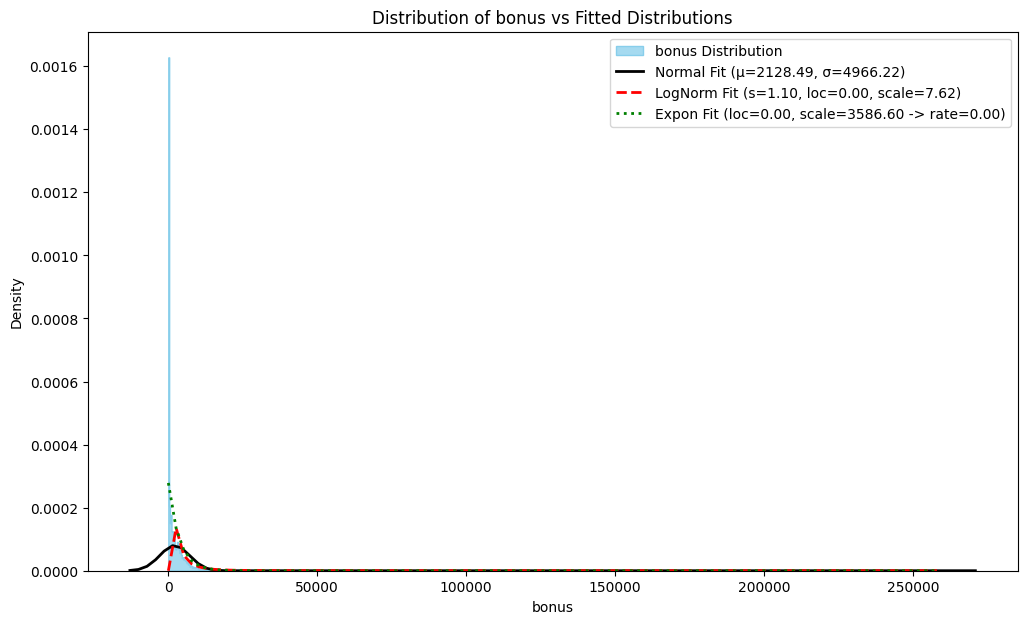

Discussion for bonus:
  Data Mean: 2128.49, Data Std Dev: 4966.44
  Skewness: 17.95, Kurtosis: 710.16
  Normal Fit: Mean (μ)=2128.49, Std Dev (σ)=4966.22
  LogNormal Fit: Shape (s)=1.10, Loc=0.00, Scale (exp(mu))=2032.33 (mu_log=7.62, sigma_log=1.10)
  Exponential Fit: Loc=0.00, Scale (1/λ)=3586.60 (Rate (λ)=0.00)
  Observations: Compare the histogram to Normal, Log-Normal, and Exponential distributions. Note skewness, presence of zeros/negatives, and how well each curve fits.
----------------------------------------------------------------------


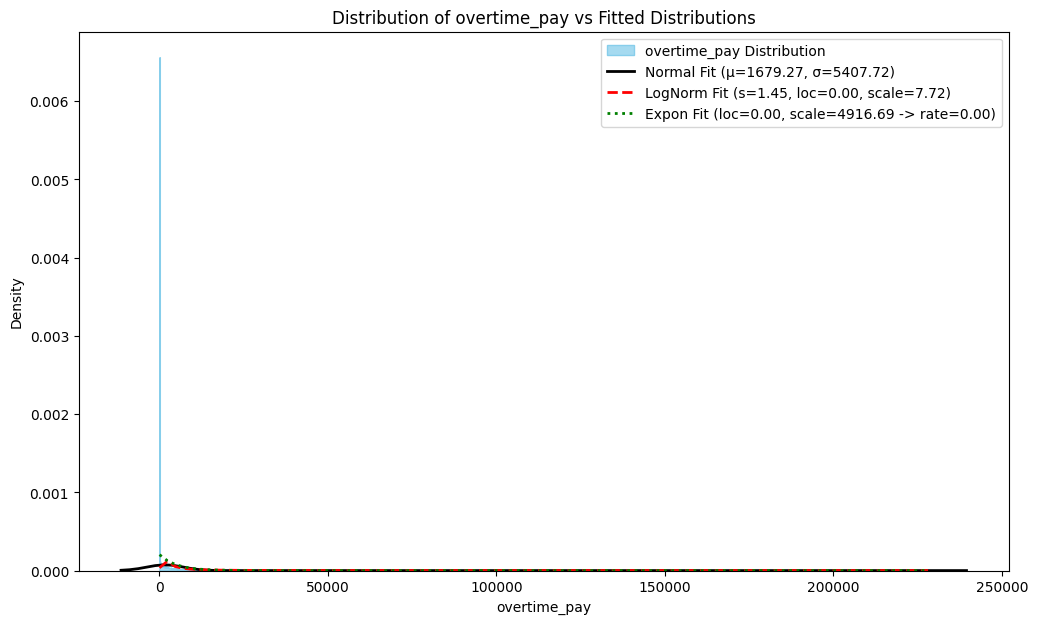

Discussion for overtime_pay:
  Data Mean: 1679.27, Data Std Dev: 5407.96
  Skewness: 15.16, Kurtosis: 440.13
  Normal Fit: Mean (μ)=1679.27, Std Dev (σ)=5407.72
  LogNormal Fit: Shape (s)=1.45, Loc=0.00, Scale (exp(mu))=2262.42 (mu_log=7.72, sigma_log=1.45)
  Exponential Fit: Loc=0.00, Scale (1/λ)=4916.69 (Rate (λ)=0.00)
  Observations: Compare the histogram to Normal, Log-Normal, and Exponential distributions. Note skewness, presence of zeros/negatives, and how well each curve fits.
----------------------------------------------------------------------


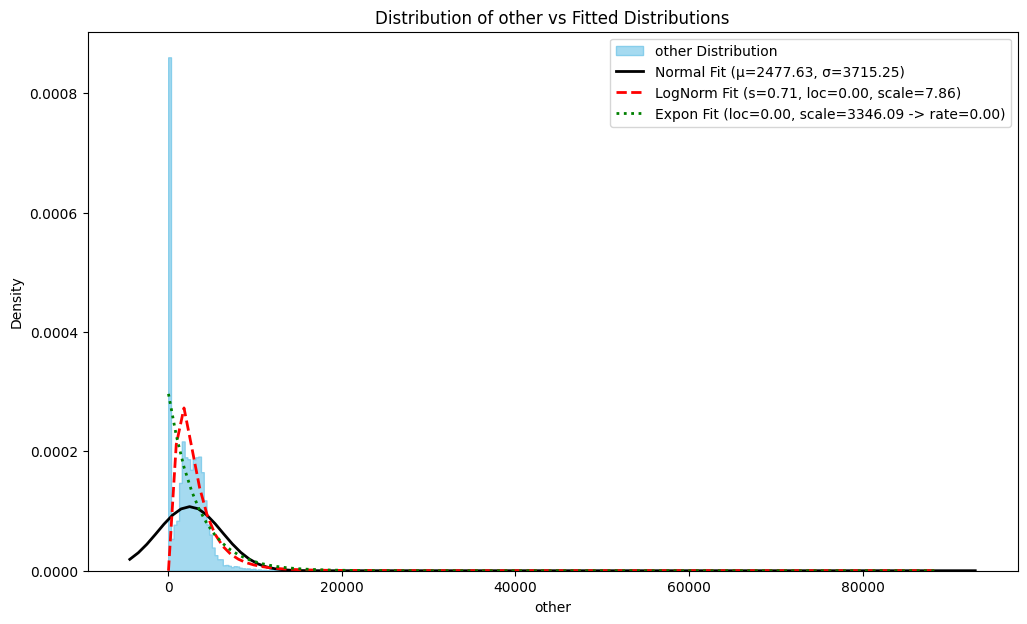

Discussion for other:
  Data Mean: 2477.63, Data Std Dev: 3715.42
  Skewness: 8.82, Kurtosis: 119.62
  Normal Fit: Mean (μ)=2477.63, Std Dev (σ)=3715.25
  LogNormal Fit: Shape (s)=0.71, Loc=0.00, Scale (exp(mu))=2592.78 (mu_log=7.86, sigma_log=0.71)
  Exponential Fit: Loc=0.00, Scale (1/λ)=3346.09 (Rate (λ)=0.00)
  Observations: Compare the histogram to Normal, Log-Normal, and Exponential distributions. Note skewness, presence of zeros/negatives, and how well each curve fits.
----------------------------------------------------------------------


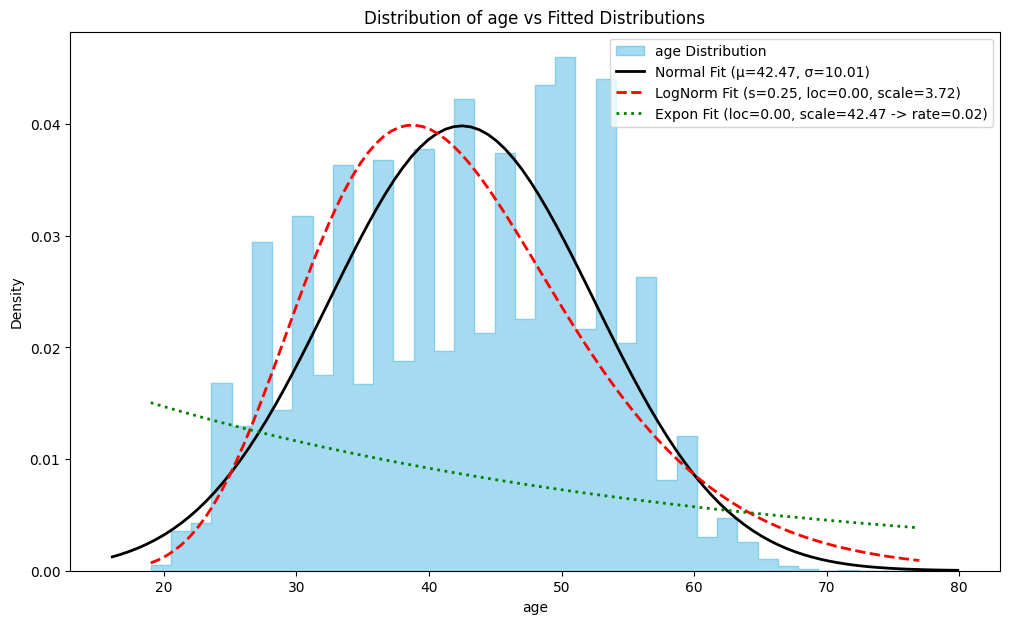

Discussion for age:
  Data Mean: 42.47, Data Std Dev: 10.01
  Skewness: -0.08, Kurtosis: -0.91
  Normal Fit: Mean (μ)=42.47, Std Dev (σ)=10.01
  LogNormal Fit: Shape (s)=0.25, Loc=0.00, Scale (exp(mu))=41.22 (mu_log=3.72, sigma_log=0.25)
  Exponential Fit: Loc=0.00, Scale (1/λ)=42.47 (Rate (λ)=0.02)
  Observations: Compare the histogram to Normal, Log-Normal, and Exponential distributions. Note skewness, presence of zeros/negatives, and how well each curve fits.
----------------------------------------------------------------------


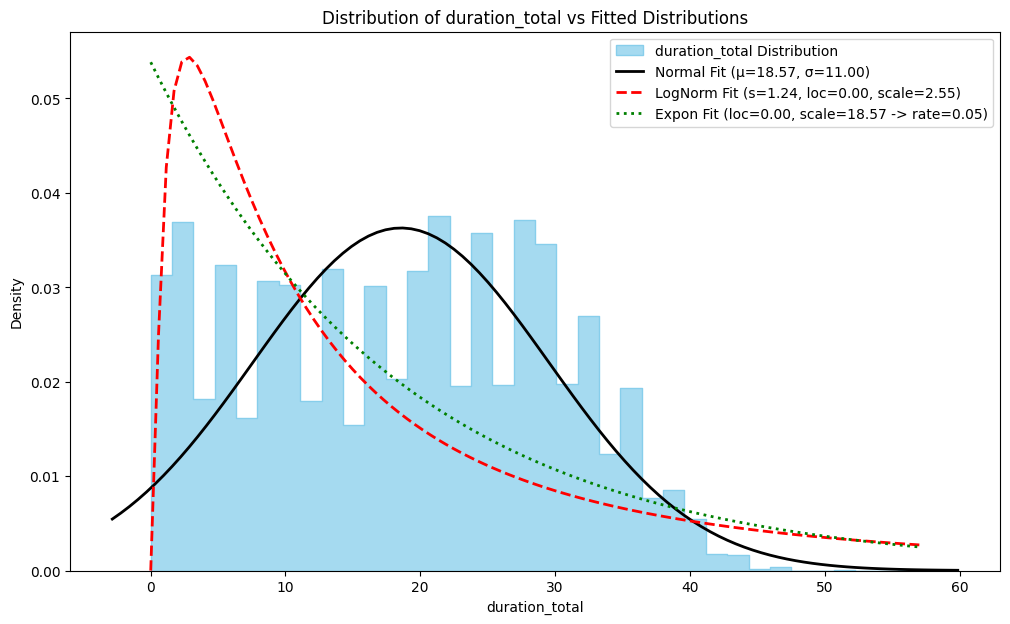

Discussion for duration_total:
  Data Mean: 18.57, Data Std Dev: 11.00
  Skewness: 0.04, Kurtosis: -1.04
  Normal Fit: Mean (μ)=18.57, Std Dev (σ)=11.00
  LogNormal Fit: Shape (s)=1.24, Loc=0.00, Scale (exp(mu))=12.75 (mu_log=2.55, sigma_log=1.24)
  Exponential Fit: Loc=0.00, Scale (1/λ)=18.57 (Rate (λ)=0.05)
  Observations: Compare the histogram to Normal, Log-Normal, and Exponential distributions. Note skewness, presence of zeros/negatives, and how well each curve fits.
----------------------------------------------------------------------


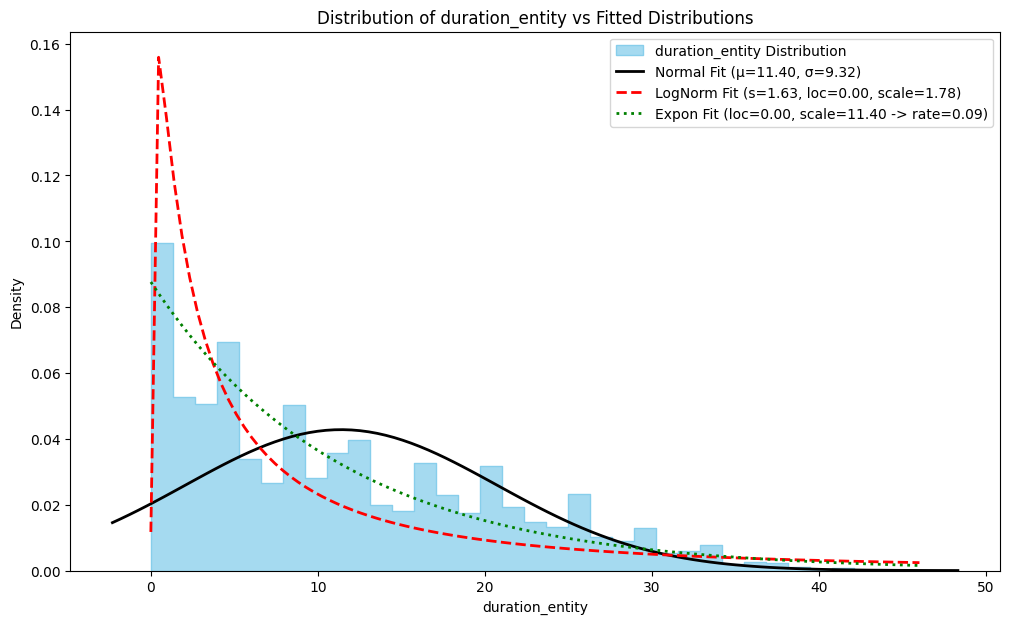

Discussion for duration_entity:
  Data Mean: 11.40, Data Std Dev: 9.32
  Skewness: 0.75, Kurtosis: -0.29
  Normal Fit: Mean (μ)=11.40, Std Dev (σ)=9.32
  LogNormal Fit: Shape (s)=1.63, Loc=0.00, Scale (exp(mu))=5.92 (mu_log=1.78, sigma_log=1.63)
  Exponential Fit: Loc=0.00, Scale (1/λ)=11.40 (Rate (λ)=0.09)
  Observations: Compare the histogram to Normal, Log-Normal, and Exponential distributions. Note skewness, presence of zeros/negatives, and how well each curve fits.
----------------------------------------------------------------------


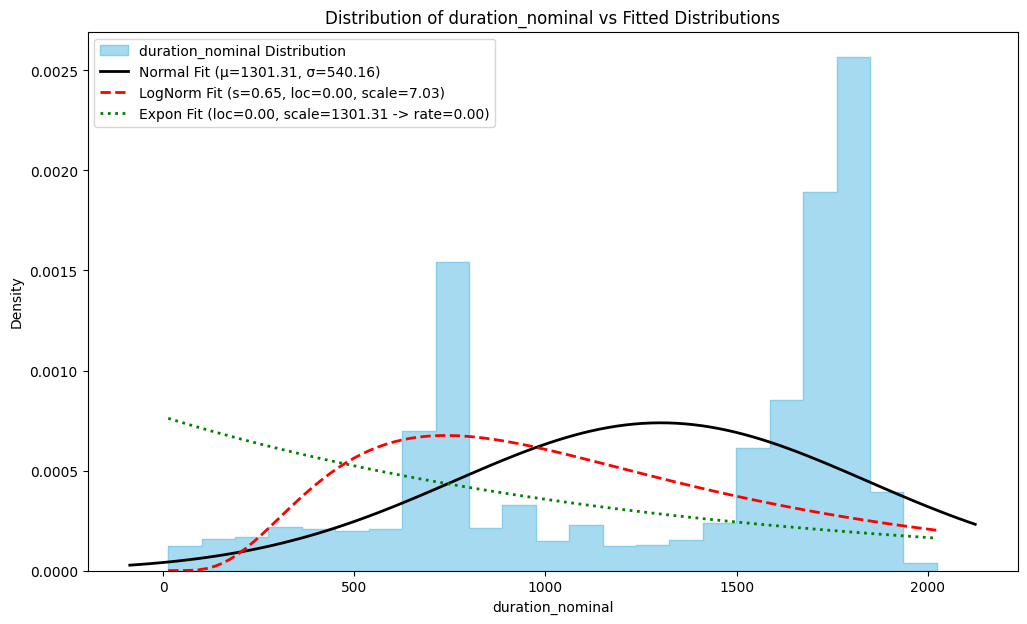

Discussion for duration_nominal:
  Data Mean: 1301.31, Data Std Dev: 540.19
  Skewness: -0.61, Kurtosis: -1.11
  Normal Fit: Mean (μ)=1301.31, Std Dev (σ)=540.16
  LogNormal Fit: Shape (s)=0.65, Loc=0.00, Scale (exp(mu))=1124.50 (mu_log=7.03, sigma_log=0.65)
  Exponential Fit: Loc=0.00, Scale (1/λ)=1301.31 (Rate (λ)=0.00)
  Observations: Compare the histogram to Normal, Log-Normal, and Exponential distributions. Note skewness, presence of zeros/negatives, and how well each curve fits.
----------------------------------------------------------------------


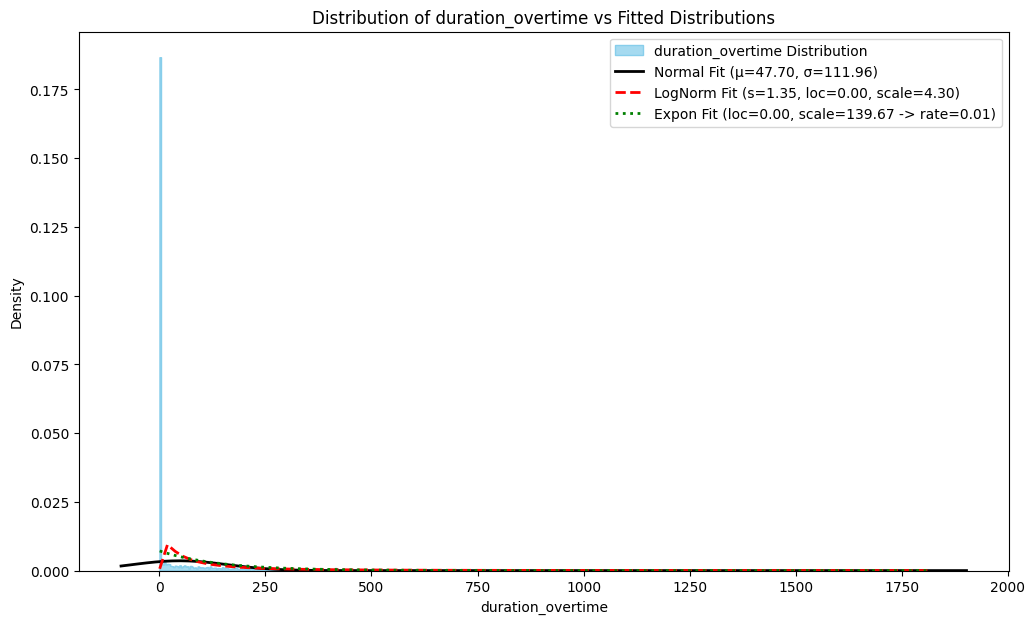

Discussion for duration_overtime:
  Data Mean: 47.70, Data Std Dev: 111.96
  Skewness: 4.81, Kurtosis: 38.71
  Normal Fit: Mean (μ)=47.70, Std Dev (σ)=111.96
  LogNormal Fit: Shape (s)=1.35, Loc=0.00, Scale (exp(mu))=73.93 (mu_log=4.30, sigma_log=1.35)
  Exponential Fit: Loc=0.00, Scale (1/λ)=139.67 (Rate (λ)=0.01)
  Observations: Compare the histogram to Normal, Log-Normal, and Exponential distributions. Note skewness, presence of zeros/negatives, and how well each curve fits.
----------------------------------------------------------------------


In [60]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm, lognorm, expon
import numpy as np

# Quantitative columns were previously defined as:
# quantitative_cols = ['base', 'bonus', 'overtime_pay', 'other', 'age', 'duration_total', 'duration_entity', 'duration_nominal', 'duration_overtime']
# We will use this list. Ensure df is loaded and quantitative_cols is defined.

if 'df' not in locals():
    print("DataFrame 'df' not found. Please ensure it is loaded correctly.")
elif 'quantitative_cols' not in locals():
    print("List 'quantitative_cols' not found. Please ensure it is defined.")
else:
    for col in quantitative_cols:
        plt.figure(figsize=(12, 7))
        
        # Plot histogram of the original data for density
        sns.histplot(df[col].dropna(), kde=False, stat="density", label=f'{col} Distribution', color='skyblue', element="step")
        
        # --- Normal Distribution Fit ---
        data_normal_fit = df[col].dropna()
        if not data_normal_fit.empty:
            mu_norm, std_norm = norm.fit(data_normal_fit)
            xmin, xmax = plt.xlim()
            x_norm = np.linspace(xmin, xmax, 100)
            p_norm = norm.pdf(x_norm, mu_norm, std_norm)
            plt.plot(x_norm, p_norm, 'k', linewidth=2, label=f'Normal Fit (\u03BC={mu_norm:.2f}, \u03C3={std_norm:.2f})')
        else:
            mu_norm, std_norm = np.nan, np.nan
            print(f"Skipping Normal fit for {col} due to no data after dropna.")
        
        # Data for distributions requiring positive values
        data_positive_fit = df[col][df[col] > 0].dropna()
        
        # --- Log-Normal Distribution Fit ---
        if not data_positive_fit.empty:
            try:
                shape_ln, loc_ln, scale_ln = lognorm.fit(data_positive_fit, floc=0) # floc=0 to fix location for some datasets
                x_ln = np.linspace(data_positive_fit.min(), data_positive_fit.max(), 100)
                p_ln = lognorm.pdf(x_ln, shape_ln, loc=loc_ln, scale=scale_ln)
                plt.plot(x_ln, p_ln, 'r--', linewidth=2, label=f'LogNorm Fit (s={shape_ln:.2f}, loc={loc_ln:.2f}, scale={np.log(scale_ln):.2f})')
            except Exception as e:
                print(f"Could not fit Log-Normal for {col}: {e}")
                shape_ln, loc_ln, scale_ln = np.nan, np.nan, np.nan
        else:
            print(f"Skipping Log-Normal fit for {col} due to no positive data after dropna.")
            shape_ln, loc_ln, scale_ln = np.nan, np.nan, np.nan
            
        # --- Exponential Distribution Fit ---
        if not data_positive_fit.empty:
            try:
                loc_exp, scale_exp = expon.fit(data_positive_fit, floc=0) # floc=0 to fix location
                x_exp = np.linspace(data_positive_fit.min(), data_positive_fit.max(), 100)
                p_exp = expon.pdf(x_exp, loc=loc_exp, scale=scale_exp)
                plt.plot(x_exp, p_exp, 'g:', linewidth=2, label=f'Expon Fit (loc={loc_exp:.2f}, scale={scale_exp:.2f} -> rate={1/scale_exp:.2f})')
            except Exception as e:
                print(f"Could not fit Exponential for {col}: {e}")
                loc_exp, scale_exp = np.nan, np.nan
        else:
            print(f"Skipping Exponential fit for {col} due to no positive data after dropna.")
            loc_exp, scale_exp = np.nan, np.nan
        
        title = f"Distribution of {col} vs Fitted Distributions"
        plt.title(title)
        plt.xlabel(col)
        plt.ylabel("Density")
        plt.legend()
        plt.show()
        
        print(f"Discussion for {col}:")
        print(f"  Data Mean: {df[col].mean():.2f}, Data Std Dev: {df[col].std():.2f}\n  Skewness: {df[col].skew():.2f}, Kurtosis: {df[col].kurtosis():.2f}")
        if not np.isnan(mu_norm): print(f"  Normal Fit: Mean (\u03BC)={mu_norm:.2f}, Std Dev (\u03C3)={std_norm:.2f}")
        if not np.isnan(shape_ln): print(f"  LogNormal Fit: Shape (s)={shape_ln:.2f}, Loc={loc_ln:.2f}, Scale (exp(mu))={scale_ln:.2f} (mu_log={np.log(scale_ln):.2f}, sigma_log={shape_ln:.2f})")
        if not np.isnan(loc_exp): print(f"  Exponential Fit: Loc={loc_exp:.2f}, Scale (1/\u03BB)={scale_exp:.2f} (Rate (\u03BB)={1/scale_exp if scale_exp > 0 else np.nan:.2f})")
        print("  Observations: Compare the histogram to Normal, Log-Normal, and Exponential distributions. Note skewness, presence of zeros/negatives, and how well each curve fits.")
        print("-"*70)

### TASK 2

## Approach to Variable Selection and Transformation for Clustering Analysis

The goal of this analysis is to identify distinct groups of employees based on their earnings and other characteristics using Agglomerative Clustering. This requires careful selection and preparation of variables.

### 1. Variable Selection

The dataset contains various pieces of information about employees. For clustering, we selected a combination of quantitative (numerical) and qualitative (categorical) variables.

**Quantitative Variables Chosen:**

*   `base`: Base salary.
*   `bonus`: Bonus amount.
*   `overtime_pay`: Pay for overtime work.
*   `other`: Other forms of remuneration.
*   `age`: Age of the employee.
*   `duration_total`: Total duration of employment in years.
*   `duration_entity`: Duration of employment in the current entity in years.
*   `duration_nominal`: Nominal hours worked.
*   `duration_overtime`: Overtime hours worked.

**Justification for Quantitative Variables:**
These variables represent the primary financial components of an employee's earnings and key demographic/employment history aspects (age, tenure, work hours). They are inherently numerical and provide a strong basis for differentiating employee groups based on their compensation structure and work patterns. The `id` column was excluded as it serves only as an identifier and holds no analytical value for clustering.

**Qualitative Variables Chosen:**

*   `sector`: Sector of employment (e.g., public, private - numerically coded in the data).
*   `section_07`: Section based on NACE classification (numerically coded).
*   `sex`: Sex of the employee (numerically coded, e.g., 1 for Male, 2 for Female).
*   `education`: Level of education (numerically coded).
*   `contract`: Type of contract (numerically coded).

**Justification for Qualitative Variables:**
These variables offer important context about the employees and their work environment. Although they are already numerically coded in the provided dataset, they represent distinct categories. Including them can help in forming more meaningful and interpretable clusters. For instance, clusters might emerge that are predominantly from a specific sector, or have a particular education level or contract type.

### 2. Variable Transformations

To prepare the data for the Agglomerative Clustering algorithm, two main types of transformations were applied:

**a. Encoding Qualitative Variables:**

*   **Method Used:** `LabelEncoder` from the `scikit-learn` library.
*   **Transformation Details:** `LabelEncoder` was applied to each of the selected qualitative variables (`sector`, `section_07`, `sex`, `education`, `contract`). This encoder assigns a unique integer to each unique category within a feature. For example, if 'sex' has categories 'Male' (coded as 1 in the original data) and 'Female' (coded as 2), `LabelEncoder` might transform these into 0 and 1 respectively (or a similar 0-indexed integer mapping).
*   **Justification:**
    *   **Algorithm Requirement:** Agglomerative Clustering operates on numerical data.
    *   **Categorical Nature:** The qualitative variables, despite being numerically coded in the source file, represent categories. `LabelEncoder` ensures these are treated as distinct categorical inputs and are converted to a standard format (typically 0 to n-1 classes) suitable for many machine learning algorithms.
    *   **Simplicity:** While One-Hot Encoding is an alternative that avoids imposing an ordinal relationship (which `LabelEncoder` might implicitly suggest if the numbers were arbitrary), `LabelEncoder` was chosen for its simplicity in this initial approach. Given that the original data already used numerical codes for these categories, `LabelEncoder` primarily serves to standardize these into a 0-indexed format if they weren't already.

**b. Scaling Quantitative Variables:**

*   **Method Used:** `StandardScaler` from the `scikit-learn` library.
*   **Transformation Details:** `StandardScaler` was applied to all selected quantitative variables. This method standardizes features by subtracting the mean and then dividing by the standard deviation. Each transformed feature will have a mean of 0 and a standard deviation of 1. The formula for a sample `x` is: `z = (x - u) / s` (where `u` is the mean and `s` is the standard deviation).
*   **Justification:**
    *   **Distance-Based Algorithm:** Agglomerative Clustering relies on distance measures (typically Euclidean distance) to determine the similarity between data points.
    *   **Preventing Dominance:** Variables with larger absolute values or wider ranges (e.g., `base` salary) can disproportionately influence these distance calculations compared to variables with smaller values (e.g., `age`), potentially skewing the clustering results.
    *   **Equal Contribution:** `StandardScaler` transforms the data so that all quantitative variables have a similar scale (mean of 0, standard deviation of 1). This ensures that each variable contributes more equally to the clustering process, leading to more balanced and meaningful cluster formations.

By performing these selection and transformation steps, the dataset is appropriately prepared for the Agglomerative Clustering algorithm, enabling it to effectively identify underlying patterns and group similar employees based on a comprehensive set of their financial and descriptive characteristics.

In [51]:
# --- Task 3: Data Preparation for Classification Models ---
# Ensure df is loaded from 'earnings.csv' (from Task 1)
# Required imports: pandas, numpy, ColumnTransformer, StandardScaler, OneHotEncoder, train_test_split

df_task3 = df.copy() # Work on a copy

# 1. Create the target variable 'has_higher_education'
df_task3['has_higher_education'] = (df_task3['education'] <= 2).astype(int)

# 2. Define features (X) and target (y)
# Numerical features (excluding 'education' as it forms the target)
numerical_features = ['age', 'base', 'bonus', 'overtime_pay', 'other', 
                    'duration_total', 'duration_entity', 'duration_nominal', 'duration_overtime']
# Categorical features (excluding 'education')
categorical_features = ['sector', 'section_07', 'sex', 'contract']

# Ensure all specified features exist in the DataFrame
all_expected_features = numerical_features + categorical_features
existing_cols_in_df = df_task3.columns.tolist()

# Filter features to only those present in the DataFrame to avoid errors
numerical_features = [col for col in numerical_features if col in existing_cols_in_df]
categorical_features = [col for col in categorical_features if col in existing_cols_in_df]

if not (numerical_features + categorical_features):
    raise ValueError("No features selected or available in the DataFrame. Check feature lists and df columns.")

X = df_task3[numerical_features + categorical_features]
y = df_task3['has_higher_education']

# 3. Create a preprocessor object using ColumnTransformer
transformers = []
if numerical_features:
    transformers.append(('num', StandardScaler(), numerical_features))
if categorical_features:
    # handle_unknown='ignore' will prevent errors if new categories appear in test data
    transformers.append(('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features))

if not transformers:
    raise ValueError("No transformers defined. Ensure numerical_features or categorical_features lists are populated.")
    
preprocessor = ColumnTransformer(transformers=transformers, remainder='drop')

# 4. Split data into training and testing sets
# stratify=y is good for classification tasks to maintain class proportion in splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# 5. Apply preprocessing
# Fit the preprocessor on the training data and transform both training and test data
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print("Data preparation for Task 3 classification models complete.")
print(f"X_train_processed shape: {X_train_processed.shape}")
print(f"X_test_processed shape: {X_test_processed.shape}")
print("y_train distribution:")
print(f"{y_train.value_counts(normalize=True)}")
print("y_test distribution:")
print(f"{y_test.value_counts(normalize=True)}")

Data preparation for Task 3 classification models complete.
X_train_processed shape: (7700, 18)
X_test_processed shape: (3300, 18)
y_train distribution:
has_higher_education
1    0.642078
0    0.357922
Name: proportion, dtype: float64
y_test distribution:
has_higher_education
1    0.642121
0    0.357879
Name: proportion, dtype: float64


In [52]:
# --- Logistic Regression Model ---
# X_train_processed, y_train, X_test_processed, y_test should be available from Task 3 data preparation

print("\n--- Logistic Regression Results ---")

# Initialize and train the Logistic Regression model
log_reg_model = LogisticRegression(random_state=42, solver='liblinear', max_iter=1000)
log_reg_model.fit(X_train_processed, y_train)

# Make predictions on the test set
y_pred_log_reg = log_reg_model.predict(X_test_processed)

# Evaluate the model
log_reg_accuracy = accuracy_score(y_test, y_pred_log_reg)
log_reg_conf_matrix = confusion_matrix(y_test, y_pred_log_reg)
log_reg_class_report = classification_report(y_test, y_pred_log_reg, zero_division=0)

print(f"Logistic Regression Accuracy: {log_reg_accuracy:.4f}")
print("\nLogistic Regression Confusion Matrix:")
print(log_reg_conf_matrix)
print("\nLogistic Regression Classification Report:")
print(log_reg_class_report)

# Print unique values in y_test and y_pred_log_reg to understand the report better
print(f"\nUnique values in y_test: {np.unique(y_test)}")
print(f"Unique values in y_pred_log_reg: {np.unique(y_pred_log_reg)}")


--- Logistic Regression Results ---
Logistic Regression Accuracy: 0.8582

Logistic Regression Confusion Matrix:
[[ 944  237]
 [ 231 1888]]

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.80      0.80      1181
           1       0.89      0.89      0.89      2119

    accuracy                           0.86      3300
   macro avg       0.85      0.85      0.85      3300
weighted avg       0.86      0.86      0.86      3300


Unique values in y_test: [0 1]
Unique values in y_pred_log_reg: [0 1]


### Assessing Logistic Regression Model Quality with Cross-Validation

To get a more reliable estimate of the Logistic Regression model's performance on unseen data, we use k-fold cross-validation. This technique helps to mitigate issues like overfitting to a specific train-test split and provides a more robust measure of generalization.

**Methodology:**

1.  **Pipeline:** A pipeline was constructed combining the same preprocessing steps (Standard Scaling for numerical features, One-Hot Encoding for categorical features) and the Logistic Regression model. This ensures that preprocessing is applied correctly and independently within each fold of the cross-validation, preventing data leakage.
2.  **Data:** The cross-validation was performed on the original training set (`X_train`, `y_train`).
3.  **K-Fold Strategy:** We used Stratified K-Fold with 5 splits (`StratifiedKFold(n_splits=5, shuffle=True, random_state=42)`). Stratification ensures that each fold maintains approximately the same percentage of samples of each target class as the complete set, which is important for classification tasks, especially with imbalanced datasets.
4.  **Metrics:** The model was evaluated using Accuracy, Weighted Precision, Weighted Recall, and Weighted F1-Score.

**Interpretation of Results:**

The output from the cross-validation provides the mean and standard deviation for each metric across the 5 folds:

*   **Mean:** The average performance for that metric. This is our primary estimate of how the model is expected to perform on unseen data.
*   **Standard Deviation (Std):** This indicates the variability of the metric. A smaller standard deviation suggests consistent performance across different data subsets.

These cross-validated scores are generally a better indicator of the model's true predictive power on new data than scores from a single train-test split.

In [53]:
# --- Linear Discriminant Analysis (LDA) Model ---
# X_train_processed, y_train, X_test_processed, y_test are from Task 3 data preparation

print("\n--- Linear Discriminant Analysis (LDA) Results ---")

# Initialize and train the LDA model
lda_model = LinearDiscriminantAnalysis()
lda_model.fit(X_train_processed, y_train)

# Make predictions on the test set
y_pred_lda = lda_model.predict(X_test_processed)

# Evaluate the model
lda_accuracy = accuracy_score(y_test, y_pred_lda)
lda_conf_matrix = confusion_matrix(y_test, y_pred_lda)
lda_class_report = classification_report(y_test, y_pred_lda, zero_division=0)

print(f"LDA Accuracy: {lda_accuracy:.4f}")
print("\nLDA Confusion Matrix:")
print(lda_conf_matrix)
print("\nLDA Classification Report:")
print(lda_class_report)

print(f"\nUnique values in y_test: {np.unique(y_test)}")
print(f"Unique values in y_pred_lda: {np.unique(y_pred_lda)}")


--- Linear Discriminant Analysis (LDA) Results ---
LDA Accuracy: 0.8482

LDA Confusion Matrix:
[[ 947  234]
 [ 267 1852]]

LDA Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.80      0.79      1181
           1       0.89      0.87      0.88      2119

    accuracy                           0.85      3300
   macro avg       0.83      0.84      0.84      3300
weighted avg       0.85      0.85      0.85      3300


Unique values in y_test: [0 1]
Unique values in y_pred_lda: [0 1]


### Assessing LDA Model Quality with Cross-Validation\n
\n
To get a more reliable estimate of the Linear Discriminant Analysis (LDA) model's performance on unseen data, we use k-fold cross-validation. This technique helps to mitigate issues like overfitting to a specific train-test split and provides a more robust measure of generalization.\n
\n
**Methodology:**\n
\n
1.  **Pipeline:** A pipeline was constructed combining the same preprocessing steps (Standard Scaling for numerical features, One-Hot Encoding for categorical features) and the LDA model. This ensures that preprocessing is applied correctly and independently within each fold of the cross-validation, preventing data leakage.\n
2.  **Data:** The cross-validation was performed on the original training set (`X_train`, `y_train`).\n
3.  **K-Fold Strategy:** We used Stratified K-Fold with 5 splits (`StratifiedKFold(n_splits=5, shuffle=True, random_state=42)`). Stratification ensures that each fold maintains approximately the same percentage of samples of each target class as the complete set, which is important for classification tasks, especially with imbalanced datasets.\n
4.  **Metrics:** The model was evaluated using Accuracy, Weighted Precision, Weighted Recall, and Weighted F1-Score.\n
\n
**Interpretation of Results:**\n
\n
The output from the cross-validation provides the mean and standard deviation for each metric across the 5 folds:\n
\n
*   **Mean:** The average performance for that metric. This is our primary estimate of how the LDA model is expected to perform on unseen data.\n
*   **Standard Deviation (Std):** This indicates the variability of the metric. A smaller standard deviation suggests consistent performance across different data subsets.\n
\n
These cross-validated scores are generally a better indicator of the model's true predictive power on new data than scores from a single train-test split.

### Assessing QDA Model Quality with Cross-Validation\n
\n
To obtain a more robust evaluation of the Quadratic Discriminant Analysis (QDA) model's performance and its ability to generalize to unseen data, we employ k-fold cross-validation.\n
\n
**Methodology:**\n
\n
1.  **Pipeline:** A pipeline was created, integrating the same preprocessing steps used for other models (Standard Scaling for numerical features, One-Hot Encoding for categorical features) with the QDA classifier. This ensures that preprocessing is applied consistently and independently within each fold, preventing data leakage from the validation set into the training process of that fold.\n
2.  **Data:** The cross-validation was performed on the original training dataset (`X_train`, `y_train`).\n
3.  **K-Fold Strategy:** We utilized Stratified K-Fold with 5 splits (`StratifiedKFold(n_splits=5, shuffle=True, random_state=42)`). Stratification ensures that each fold reflects the class distribution of the original dataset, which is crucial for reliable classification model evaluation, particularly with imbalanced classes.\n
4.  **Metrics:** The QDA model was evaluated using key classification metrics: Accuracy, Weighted Precision, Weighted Recall, and Weighted F1-Score.\n
\n
**Interpretation of Results:**\n
\n
The cross-validation process yields the mean and standard deviation for each evaluation metric across the 5 folds:\n
\n
*   **Mean:** This represents the average performance of the QDA model for a given metric. It serves as our primary estimate of how the model is likely to perform on new, unseen data.\n
*   **Standard Deviation (Std):** This measures the variability or spread of the metric scores across the different folds. A lower standard deviation indicates more consistent performance, suggesting that the model is not overly sensitive to the specific subsets of data used for training and validation within the folds.\n
\n
These cross-validated scores provide a more dependable assessment of the QDA model's predictive capabilities compared to scores from a single train-test split, as they account for variability in data sampling.

In [54]:
# --- K-Nearest Neighbors (KNN) Model ---
# X_train_processed, y_train, X_test_processed, y_test are from Task 3 data preparation

print("\n--- K-Nearest Neighbors (KNN) Results ---")

# Initialize and train the KNN model (e.g., with k=5 neighbors)
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_processed, y_train)

# Make predictions on the test set
y_pred_knn = knn_model.predict(X_test_processed)

# Evaluate the model
knn_accuracy = accuracy_score(y_test, y_pred_knn)
knn_conf_matrix = confusion_matrix(y_test, y_pred_knn)
knn_class_report = classification_report(y_test, y_pred_knn, zero_division=0)

print(f"KNN Accuracy (k=5): {knn_accuracy:.4f}")
print("\nKNN Confusion Matrix (k=5):")
print(knn_conf_matrix)
print("\nKNN Classification Report (k=5):")
print(knn_class_report)

print(f"\nUnique values in y_test: {np.unique(y_test)}")
print(f"Unique values in y_pred_knn: {np.unique(y_pred_knn)}")


--- K-Nearest Neighbors (KNN) Results ---
KNN Accuracy (k=5): 0.8512

KNN Confusion Matrix (k=5):
[[ 953  228]
 [ 263 1856]]

KNN Classification Report (k=5):
              precision    recall  f1-score   support

           0       0.78      0.81      0.80      1181
           1       0.89      0.88      0.88      2119

    accuracy                           0.85      3300
   macro avg       0.84      0.84      0.84      3300
weighted avg       0.85      0.85      0.85      3300


Unique values in y_test: [0 1]
Unique values in y_pred_knn: [0 1]


### Assessing QDA Model Quality with Cross-Validation\n
\n
To obtain a more robust evaluation of the Quadratic Discriminant Analysis (QDA) model's performance and its ability to generalize to unseen data, we employ k-fold cross-validation.\n
\n
**Methodology:**\n
\n
1.  **Pipeline:** A pipeline was created, integrating the same preprocessing steps used for other models (Standard Scaling for numerical features, One-Hot Encoding for categorical features) with the QDA classifier. This ensures that preprocessing is applied consistently and independently within each fold, preventing data leakage from the validation set into the training process of that fold.\n
2.  **Data:** The cross-validation was performed on the original training dataset (`X_train`, `y_train`).\n
3.  **K-Fold Strategy:** We utilized Stratified K-Fold with 5 splits (`StratifiedKFold(n_splits=5, shuffle=True, random_state=42)`). Stratification ensures that each fold reflects the class distribution of the original dataset, which is crucial for reliable classification model evaluation, particularly with imbalanced classes.\n
4.  **Metrics:** The QDA model was evaluated using key classification metrics: Accuracy, Weighted Precision, Weighted Recall, and Weighted F1-Score.\n
\n
**Interpretation of Results:**\n
\n
The cross-validation process yields the mean and standard deviation for each evaluation metric across the 5 folds:\n
\n
*   **Mean:** This represents the average performance of the QDA model for a given metric. It serves as our primary estimate of how the model is likely to perform on new, unseen data.\n
*   **Standard Deviation (Std):** This measures the variability or spread of the metric scores across the different folds. A lower standard deviation indicates more consistent performance, suggesting that the model is not overly sensitive to the specific subsets of data used for training and validation within the folds.\n
\n
These cross-validated scores provide a more dependable assessment of the QDA model's predictive capabilities compared to scores from a single train-test split, as they account for variability in data sampling.